We recently launched a new measure of [seven day prescribing for long term conditions](https://openprescribing.net/measure/seven_day_prescribing/all-england/) where we found variation across the country. In the background we state that there is no consensus on duration of long term prescriptions and guidance varies throughout the country around stable long term prescriptions. Most CCGs will have some form of guidance generally for one, two or three months. 

The University of Bristol have produced a [policy briefing](https://www.bristol.ac.uk/policybristol/policy-briefings/repeat-prescription-costs/) arguing that three month repeat prescriptions are more cost-effective. They base this on a systematic review and studies in CPRD. 

I have had a quick skim of the systematic review (based exclusively on American data) and the CPRD study. The policy briefing states that _current guidance to issue 28-day repeat prescriptions_. This deviates from the DataLab assertion in the seven days measure that there is no consensus. Martin, Payne and Wilson study is is based on old guidance from a handful of areas. This notebook seeks to ascertain what the variation is in 28 v 56 v 84 across the country for our basket of medicines commonly prescribed once daily for long term conditions on the complete prescribing dataset for England.

In [4]:
##importing libraries that are need to support analysis
import pandas as pd
import numpy as np
import plotly.express as px
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import os

In [5]:
### here we extract data for modelling
sql = '''
SELECT
  pct,
  quantity_per_item,
  sum(items) as items
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN hscic.ccgs AS ccgs ON presc.pct=ccgs.code AND ccgs.org_type='CCG'

WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atrovastatin
bnf_code LIKE "0212000Y0%" OR ##simvastatin
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND (month BETWEEN '2018-08-01'
    AND '2019-07-01')

GROUP BY
  pct,
  quantity_per_item
    '''

df_ltc = bq.cached_read(sql, csv_path=os.path.join('..','data','ltc_qty.csv'))
df_ltc.head(10)

Downloading: 100%|██████████| 18131/18131 [00:00<00:00, 22928.18rows/s]


,pct,quantity_per_item,items
0,01C,42,589
1,01C,60,125
2,01C,49,6
3,01C,18,38
4,01C,51,5
5,01C,9,23
6,01C,11,127
7,01C,8,126
8,01C,20,141
9,01C,5,39


In [6]:
df_ltc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18131 entries, 0 to 18130
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   pct                18131 non-null  object
 1   quantity_per_item  18131 non-null  int64 
 2   items              18131 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 425.1+ KB


In [9]:
df_rx_repeat = df_ltc.copy()
df_rx_repeat["total_quantity"] = df_rx_repeat["quantity_per_item"]*df_rx_repeat["items"] 
df_rx_repeat.tail(5)

,pct,quantity_per_item,items,total_quantity
18126,10L,98,1,98
18127,10L,93,1,93
18128,10V,92,1,92
18129,10X,256,1,256
18130,11J,125,1,125


In [10]:
df_rx_repeat.describe()

,quantity_per_item,items,total_quantity
count,18131.000000,1.813100e+04,1.813100e+04
mean,87.149302,8.695830e+03,2.966546e+05
std,139.332568,6.840434e+04,2.275661e+06
min,1.000000,1.000000e+00,4.000000e+00
25%,25.000000,3.000000e+00,1.620000e+02
50%,52.000000,1.100000e+01,5.760000e+02
75%,104.000000,5.700000e+01,2.202000e+03
max,8400.000000,2.257196e+06,6.320149e+07


There is a maximum of 8400 on a single...... That is 23 years worth of tablets, lets investigate further below.

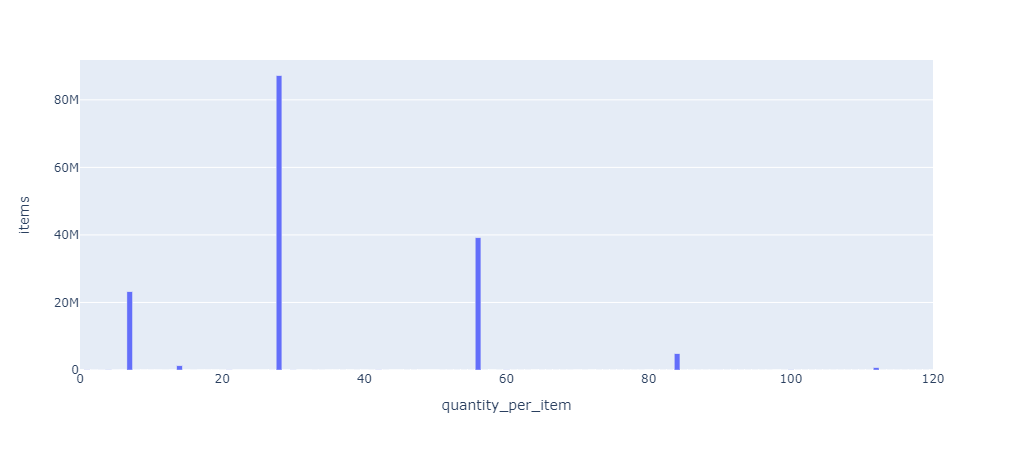

In [47]:

dfp = df_rx_repeat.copy()
dfp = dfp.groupby(["quantity_per_item"]).sum().reset_index()

fig = px.bar(dfp, x='quantity_per_item', y='items')
fig.update_xaxes(range=[0, 120])


fig.show()

In [12]:
###here we make a list of durations we want to affect for later filtering
lst = [7,28,56,84]

In [13]:
df_common = df_rx_repeat.loc[(df_rx_repeat["quantity_per_item"].isin(lst))]

print(df_common)                                                             

       pct  quantity_per_item   items  total_quantity
41     02D                  7   44753          313271
42     02D                 84    1262          106008
48     02E                 28  290091         8122548
49     02E                 56  157076         8796256
50     02E                  7   15705          109935
...    ...                ...     ...             ...
15588  11J                  7  104454          731178
15589  11J                 56  608768        34091008
15592  11J                 84   58016         4873344
15622  99M                 28  182687         5115236
15623  99M                 84   19853         1667652

[764 rows x 4 columns]


In [14]:
total = df_common["total_quantity"].sum()
df_common["proportion_of_qty"] = df_common["total_quantity"]/total*100
df_common

<ipython-input-14-26bc3bc10b27>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,pct,quantity_per_item,items,total_quantity,proportion_of_qty
41,02D,7,44753,313271,0.006023
42,02D,84,1262,106008,0.002038
48,02E,28,290091,8122548,0.156178
49,02E,56,157076,8796256,0.169132
50,02E,7,15705,109935,0.002114
...,...,...,...,...,...
15588,11J,7,104454,731178,0.014059
15589,11J,56,608768,34091008,0.655493
15592,11J,84,58016,4873344,0.093703
15622,99M,28,182687,5115236,0.098354


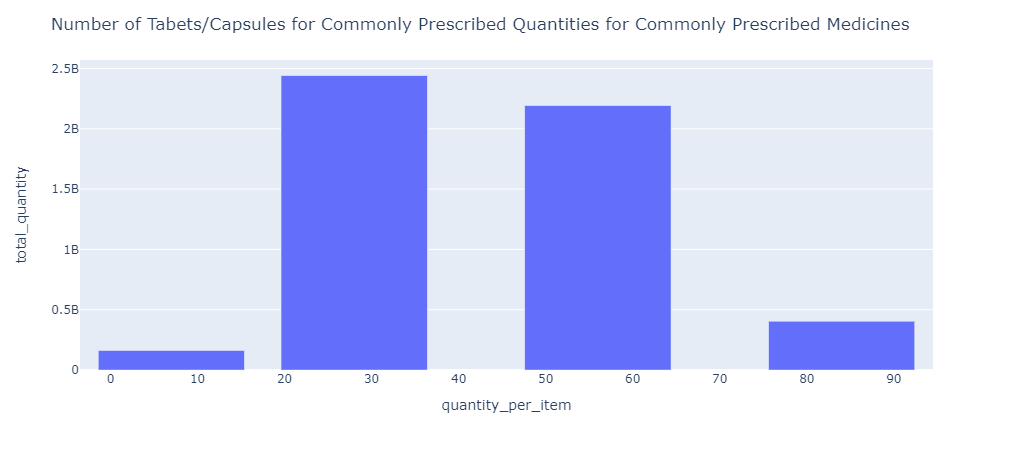

In [17]:
dfp = df_common.copy()
dfp = dfp.groupby(["quantity_per_item"]).sum().reset_index()

fig = px.bar(dfp, x='quantity_per_item', y='total_quantity')
fig.update_layout(
    title="Number of Tabets/Capsules for Commonly Prescribed Quantities for Commonly Prescribed Medicines")
fig.show()


Most tablets/capsules for common LTC medicines are being dispensed on 28 day prescriptions (59%) with approximately 33% being dispensed on two monthly scripts. Only 4.5% of these common medicines are being supplied on three onthly prescriptions. 

The Bristol paper assertion that most prescribing is 28 days is correct based on our basket of common LTC medicines. They recommend three month presctiptions as being more cost effective. Now lets look at script volume to see what the workload implications might be for our basket of common medicines.

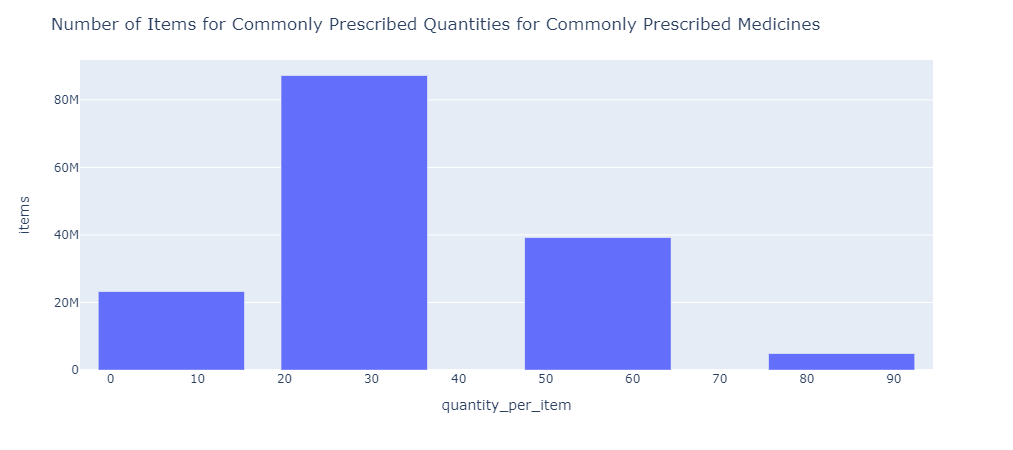

There are 8.7M one-month scripts for our basket of common medicines. There will be substantial number of prescriptions that need amending.


In [27]:
fig = px.bar(dfp, x='quantity_per_item', y='items')
fig.update_layout(
    title="Number of Items for Commonly Prescribed Quantities for Commonly Prescribed Medicines")
fig.show()
items_28d = dfp.loc[dfp["quantity_per_item"]==28,'items'].item()/10E6
print(f'There are {items_28d:,.1f}M one-month scripts for our basket of common medicines. There will be a substantial number of prescriptions that need amending.')

## CCG Variation

In [28]:
df_ccg = df_ltc.groupby(['pct','quantity_per_item'])['items'].sum().reset_index()
df_ccg["total_quantity"] = df_ccg["quantity_per_item"]*df_ccg["items"] 
df_ccg.tail(5)

,pct,quantity_per_item,items,total_quantity
18126,99N,300,6,1800
18127,99N,336,10,3360
18128,99N,350,13,4550
18129,99N,365,2,730
18130,99N,565,1,565


In [29]:
df_common_ccg = df_ccg.loc[(df_ccg["quantity_per_item"].isin(lst))]


In [30]:
ccg_total = df_common_ccg.groupby(["pct"]).sum().reset_index()
ccg_total=ccg_total.rename(columns = {'total_quantity':'basket_qty'}).drop(columns =['quantity_per_item', 'items']) ##we don't need two columns
ccg_total.head()

,pct,basket_qty
0,00C,10101777
1,00D,33296466
2,00J,24490340
3,00K,32534138
4,00L,36316847


In [31]:
ccg_map =  pd.merge(df_common_ccg,ccg_total, on="pct")  
ccg_map["proportion_of_basket"] = ccg_map["total_quantity"]/ccg_map["basket_qty"]*100
ccg_map.head()

,pct,quantity_per_item,items,total_quantity,basket_qty,proportion_of_basket
0,00C,7,130083,910581,10101777,9.014068
1,00C,28,87656,2454368,10101777,24.296399
2,00C,56,115772,6483232,10101777,64.179124
3,00C,84,3019,253596,10101777,2.510410
4,00D,7,426526,2985682,33296466,8.966964


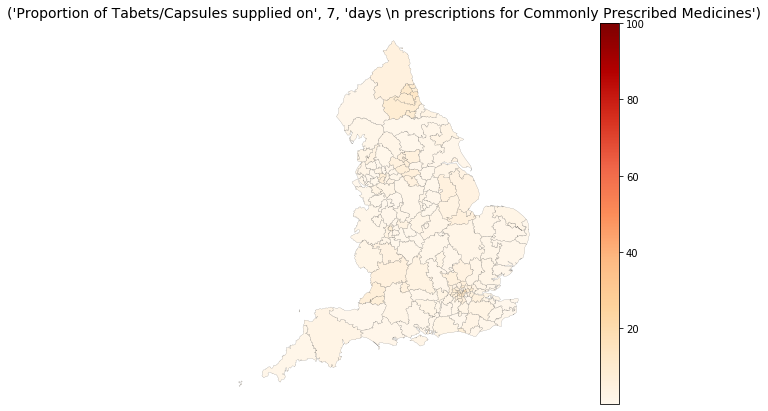

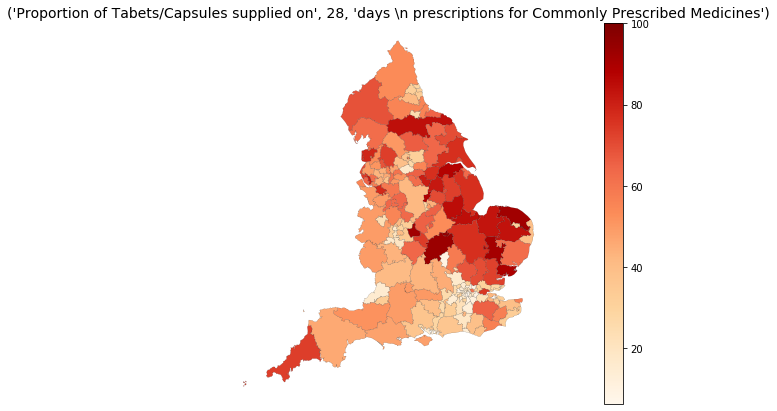

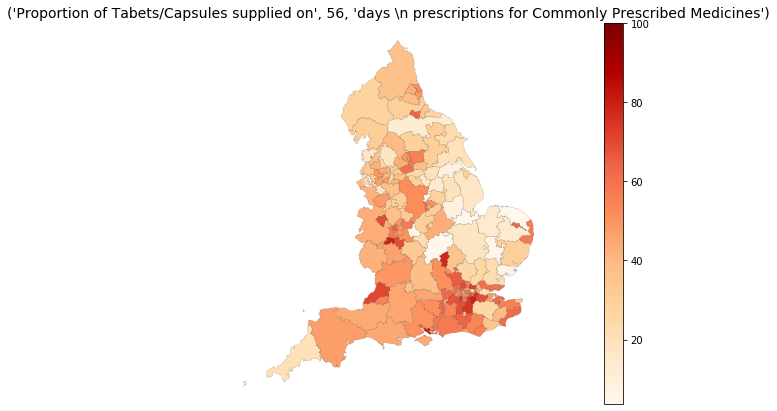

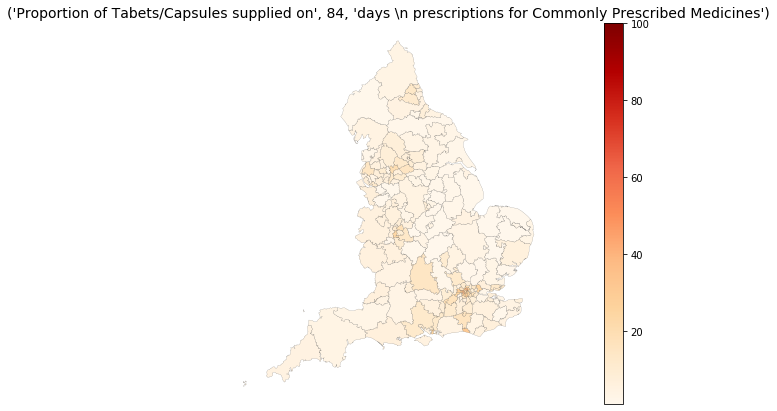

In [32]:
for quantity_per_item in ccg_map.quantity_per_item.unique():
    plt.figure(figsize=(20, 7))
    maps.ccg_map(
        ccg_map[ccg_map['quantity_per_item'] == quantity_per_item], 
        title= ("Proportion of Tabets/Capsules supplied on", quantity_per_item, "days \n prescriptions for Commonly Prescribed Medicines"),
        column='proportion_of_basket', 
        separate_london=False,
        plot_options={'vmax': 100}
    )
    plt.show()

My impression is that the 28 day supply map looks similar to SystmOne v EMIS Web [map of deployment](https://github.com/ebmdatalab/jupyter-notebooks/blob/master/General%20Practice%20EHR%20Deployment/EHR%20Deployment.ipynb)

## Excessive quantities in CCGs

Above we saw that there are some excessive quantities being prescribed, one script for 8400 would equate to 23 years supply and it was prescribed in a single month. It is unlikely that it was dispensed but we will now interrogate the data to see what the true cost of excessive prescribing is. We cannot investigate further so we will create files for interested CCGs - perhaps we could do mass audit?

In [34]:
### here we extract data for modelling
sql = '''
SELECT
  month,
  pct,
  practice,
  bnf_name,
  items,
  actual_cost,
  quantity_per_item
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN hscic.ccgs AS ccgs ON presc.pct=ccgs.code AND ccgs.org_type='CCG'

WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atrovastatin
bnf_code LIKE "0212000Y0%" OR ##simvastatin
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND (month >= '2018-08-01'
    AND month <= '2019-07-01')
AND
quantity_per_item >= 336 ##this is one years supply
    '''

df_excess = bq.cached_read(sql, csv_path=os.path.join('..','data','ltc_qty_excess.csv'))
df_excess.head(10)

Downloading: 100%|██████████| 2276/2276 [00:00<00:00, 4812.87rows/s]


,month,pct,practice,bnf_name,items,actual_cost,quantity_per_item
0,2019-06-01,02F,N81081,Levothyrox Sod_Tab 25mcg,1,27.16517,500
1,2019-06-01,00D,A83012,Levothyrox Sod_Tab 75mcg,1,106.23248,1225
2,2019-06-01,00D,A83012,Levothyrox Sod_Tab 100mcg,1,41.98797,1225
3,2019-06-01,00J,A83036,Ramipril_Cap 2.5mg,1,14.71216,400
4,2019-06-01,01G,P87634,Levothyrox Sod_Tab 25mcg,1,18.19008,336
5,2019-06-01,01Y,C81106,Amlodipine_Tab 5mg,1,7.93028,336
6,2019-06-01,01Y,C81106,Levothyrox Sod_Tab 25mcg,1,18.19008,336
7,2019-06-01,01Y,C81106,Levothyrox Sod_Tab 50mcg,1,11.49891,336
8,2019-06-01,01Y,C81106,Levothyrox Sod_Tab 100mcg,1,11.49891,336
9,2019-06-01,01Y,P89003,Levothyrox Sod_Tab 25mcg,1,18.19008,336


In [35]:
df_excess.describe()

,items,actual_cost,quantity_per_item
count,2276.000000,2276.000000,2276.000000
mean,1.074692,21.833317,422.605009
std,0.424162,54.689319,298.873079
min,1.000000,6.253670,336.000000
25%,1.000000,11.948050,336.000000
50%,1.000000,17.292860,336.000000
75%,1.000000,22.649910,420.000000
max,8.000000,2409.878090,8400.000000


In [39]:
df_excess[["items","actual_cost"]].sum()

items           2446.00000
actual_cost    49692.62845
dtype: float64

In [40]:
# here we create csv files for each CCG to investigate further if they wish - these are now available on GitHub
for i, g in df_excess.groupby('pct'):
     g.to_csv(os.path.join('..','data','{}.csv').format(i.split('/')[0]), index=False)


 code review improvements - what I would like to tweak
- Cartogram Map titles, they do not look right but it fails when I try tweaking. How do you combine the changing column title and a nonchangeable string
- csv files for each ccg. I'd like to put them in a seperate folder.
- currently has 12 months to July 19, we should update with latest if going anywhere.